# Analysis of Shanehsazzadeh et al. Data - Multiple Lengths

Analysis of binding data from Shanehsazzadeh et al using various models across different sequence lengths.

In [1]:
from collections import Counter
from dataclasses import dataclass
import io
import os
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from tqdm import tqdm
tqdm.pandas()

from netam.framework import load_crepe
from netam.sequences import translate_sequence, AA_STR_SORTED
from dnsmex.ablang_wrapper import AbLangWrapper
from dnsmex.esm_wrapper import esm2_wrapper_of_size
from dnsmex.local import localify
from dnsmex.dms_helper import protein_differences, get_site_by_site_consensus

figures_dir = localify("FIGURES_DIR")
os.makedirs("_output", exist_ok=True)

In [2]:
def mask_tensor_of_differences(max_len, differences):
    """Make a tensor that is 1 for the positions of the differences and 0 otherwise.
    
    For example, A105G would have a 1 at column 104 in the G row.
    """
    mask = torch.zeros((20, max_len))
    for diff in differences:
        site = int(diff[1:-1])
        aa2 = diff[-1]
        mask[AA_STR_SORTED.index(aa2), site - 1] = 1
    return mask

def sel_score_of_differences(dasm_scores, differences):
    """Calculate selection score for given differences using DASM scores."""
    return (dasm_scores * mask_tensor_of_differences(dasm_scores.shape[1], differences)).sum().item()

In [3]:
@dataclass
class ShaneDataPartition:
    """Class to handle analysis of a partition of the Shane data by heavy chain length."""
    length: int
    df: pd.DataFrame
    heavy_consensus: str = None
    light_consensus: str = None
    
    def __post_init__(self):
        self.heavy_consensus = get_site_by_site_consensus(self.df, "heavy")
        self.light_consensus = get_site_by_site_consensus(self.df, "light")
        
        self.df["heavy_differences"] = self.df["heavy"].apply(
            lambda x: protein_differences(self.heavy_consensus, x)
        )
        self.df["heavy_difference_count"] = self.df["heavy_differences"].apply(len)
        self.df = self.df.sort_values("heavy_difference_count").reset_index(drop=True)
    
    def add_dasm_scores(self, crepe):
        """Add DASM scores to the dataframe."""
        [[dasm_heavy, dasm_light]] = crepe([[self.heavy_consensus, self.light_consensus]])
        log_dasm_heavy = torch.log(dasm_heavy.T)
        self.df["dasm"] = self.df["heavy_differences"].apply(
            lambda x: sel_score_of_differences(log_dasm_heavy, x)
        )
    
    def add_ablang_scores(self):
        """Add AbLang scores to the dataframe."""
        ablang_wrapper = AbLangWrapper()
        heavy_light_pairs = self.df[["heavy", "light"]].apply(list, axis=1).tolist()
        self.df["ablang"] = ablang_wrapper.pseudo_perplexity(heavy_light_pairs)
    
    def add_esm_scores(self):
        """Add ESM scores to the dataframe."""
        esm_wrapper = esm2_wrapper_of_size("650M")
        self.df["esm"] = self.df["heavy"].progress_apply(esm_wrapper.pseudo_perplexity)
    
    def save(self, prefix):
        """Save the dataframe to a CSV file."""
        self.df.to_csv(f"{prefix}_len_{self.length}.csv", index=False)
    
    @classmethod
    def load(cls, prefix, length):
        """Load a partition from a CSV file."""
        df = pd.read_csv(f"{prefix}_len_{length}.csv")
        return cls(length=length, df=df)
    
    def process_perplexities(self):
        self.df["neg esm"] = -self.df["esm"]
        self.df["neg ablang"] = -self.df["ablang"]
    
    def plot_correlations(self, axs):
        """Plot correlations between model scores and experimental data on provided axes."""
        correlations = []
        for ax, model in zip(axs, ['dasm', 'neg ablang', 'neg esm', 'neg progen']):
            # Plot with transposed axes and specified color
            sns.scatterplot(
                data=self.df, 
                y=model, 
                x='-log10 KD', 
                alpha=0.5, 
                linewidth=0, 
                color='#1f78b4',
                ax=ax
            )
            sns.despine()
            
            y_axis_labels = {
                "dasm": "DASM",
                "neg ablang": "-AbLang2 perplexity",
                "neg esm": "-ESM perplexity",
                "neg progen": "-ProGen2 perplexity",
            }
            ax.set_ylabel(y_axis_labels[model])
            
            # Calculate correlation
            corr = self.df[[model, '-log10 KD']].corr().iloc[0,1]
            correlations.append([f"Shane. Trast. zero {self.length}", model, corr])
            
            # Add correlation text with specified styling
            ax.text(
                0.05, 1.02, 
                f"Pearson r: {corr:.2f}",
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='left',
                fontsize=plt.rcParams["axes.titlesize"],
                color='#6a0dad'
            )
            
            # Only show x-axis label on bottom plot
            if ax != axs[-1]:
                ax.set_xlabel('')
            
        return correlations

In [4]:
# Load and preprocess the data
zero_df = pd.read_csv(localify("DATA_DIR/Shanehsazzadeh2023_trastuzumab_zero_kd.progen2-small.csv"))
zero_df["molar KD"] = zero_df["fitness"] * 1e-9
zero_df["-log10 KD"] = -np.log10(zero_df["molar KD"])
zero_df["neg progen"] = -zero_df["average_perplexity"]
# drop all columns that end with _perplexity
zero_df = zero_df[zero_df.columns.drop(list(zero_df.filter(regex='_perplexity')))]

# Add sequence length information
zero_df["heavy_len"] = zero_df["heavy"].apply(len)
zero_df["light_len"] = zero_df["light"].apply(len)

# Create partitions for lengths 119 and 120
partitions = {}
for length in [119, 120]:
    df_subset = zero_df.groupby("heavy_len").get_group(length).copy().reset_index(drop=True)
    partitions[length] = ShaneDataPartition(length=length, df=df_subset)

In [5]:
cached_output_dir = "_ignore"

# make sure cached output directory exists
os.makedirs(cached_output_dir, exist_ok=True)

# Optional: Run expensive model evaluations
# Uncomment to run AbLang and ESM (takes a while)
for partition in partitions.values():
    partition.add_ablang_scores()
    partition.add_esm_scores()
    partition.save(f"{cached_output_dir}/partition")

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


AbLang2 pseudo-perplexity took 1907.761s


  0%|          | 0/184 [00:00<?, ?it/s]

  1%|          | 2/184 [00:04<07:32,  2.48s/it]

  2%|▏         | 3/184 [00:10<11:16,  3.74s/it]

  2%|▏         | 4/184 [00:15<13:09,  4.39s/it]

  3%|▎         | 5/184 [00:21<14:13,  4.77s/it]

  3%|▎         | 6/184 [00:27<14:56,  5.04s/it]

  4%|▍         | 7/184 [00:32<15:19,  5.19s/it]

  4%|▍         | 8/184 [00:38<15:36,  5.32s/it]

  5%|▍         | 9/184 [00:43<15:43,  5.39s/it]

  5%|▌         | 10/184 [00:49<15:47,  5.45s/it]

  6%|▌         | 11/184 [00:54<15:49,  5.49s/it]

  7%|▋         | 12/184 [01:00<15:55,  5.56s/it]

  7%|▋         | 13/184 [01:06<15:59,  5.61s/it]

  8%|▊         | 14/184 [01:12<16:01,  5.65s/it]

  8%|▊         | 15/184 [01:17<16:04,  5.71s/it]

  9%|▊         | 16/184 [01:23<16:05,  5.75s/it]

  9%|▉         | 17/184 [01:29<16:07,  5.79s/it]

 10%|▉         | 18/184 [01:35<16:06,  5.82s/it]

 10%|█         | 19/184 [01:41<16:06,  5.86s/it]

 11%|█         | 20/184 [01:47<16:03,  5.87s/it]

 11%|█▏        | 21/184 [01:53<15:58,  5.88s/it]

 12%|█▏        | 22/184 [01:59<16:01,  5.93s/it]

 12%|█▎        | 23/184 [02:05<15:56,  5.94s/it]

 13%|█▎        | 24/184 [02:12<16:32,  6.20s/it]

 14%|█▎        | 25/184 [02:18<16:28,  6.22s/it]

 14%|█▍        | 26/184 [02:24<16:06,  6.12s/it]

 15%|█▍        | 27/184 [02:30<15:52,  6.07s/it]

 15%|█▌        | 28/184 [02:36<15:40,  6.03s/it]

 16%|█▌        | 29/184 [02:42<15:30,  6.01s/it]

 16%|█▋        | 30/184 [02:47<15:19,  5.97s/it]

 17%|█▋        | 31/184 [02:53<15:09,  5.94s/it]

 17%|█▋        | 32/184 [02:59<15:04,  5.95s/it]

 18%|█▊        | 33/184 [03:05<14:55,  5.93s/it]

 18%|█▊        | 34/184 [03:11<14:42,  5.88s/it]

 19%|█▉        | 35/184 [03:17<14:27,  5.82s/it]

 20%|█▉        | 36/184 [03:22<14:12,  5.76s/it]

 20%|██        | 37/184 [03:28<13:58,  5.70s/it]

 21%|██        | 38/184 [03:33<13:46,  5.66s/it]

 21%|██        | 39/184 [03:39<13:39,  5.65s/it]

 22%|██▏       | 40/184 [03:45<13:30,  5.63s/it]

 22%|██▏       | 41/184 [03:50<13:23,  5.62s/it]

 23%|██▎       | 42/184 [03:56<13:17,  5.61s/it]

 23%|██▎       | 43/184 [04:01<13:15,  5.64s/it]

 24%|██▍       | 44/184 [04:07<13:08,  5.63s/it]

 24%|██▍       | 45/184 [04:13<13:00,  5.62s/it]

 25%|██▌       | 46/184 [04:19<13:04,  5.69s/it]

 26%|██▌       | 47/184 [04:25<13:22,  5.86s/it]

 26%|██▌       | 48/184 [04:31<13:13,  5.84s/it]

 27%|██▋       | 49/184 [04:36<13:05,  5.82s/it]

 27%|██▋       | 50/184 [04:42<12:58,  5.81s/it]

 28%|██▊       | 51/184 [04:48<12:52,  5.81s/it]

 28%|██▊       | 52/184 [04:54<12:39,  5.76s/it]

 29%|██▉       | 53/184 [04:59<12:31,  5.74s/it]

 29%|██▉       | 54/184 [05:05<12:21,  5.70s/it]

 30%|██▉       | 55/184 [05:11<12:14,  5.69s/it]

 30%|███       | 56/184 [05:16<12:05,  5.67s/it]

 31%|███       | 57/184 [05:22<12:03,  5.70s/it]

 32%|███▏      | 58/184 [05:28<12:00,  5.72s/it]

 32%|███▏      | 59/184 [05:33<11:54,  5.72s/it]

 33%|███▎      | 60/184 [05:39<12:00,  5.81s/it]

 33%|███▎      | 61/184 [05:45<11:53,  5.80s/it]

 34%|███▎      | 62/184 [05:51<11:45,  5.78s/it]

 34%|███▍      | 63/184 [05:57<11:35,  5.75s/it]

 35%|███▍      | 64/184 [06:02<11:30,  5.75s/it]

 35%|███▌      | 65/184 [06:08<11:19,  5.71s/it]

 36%|███▌      | 66/184 [06:14<11:32,  5.87s/it]

 36%|███▋      | 67/184 [06:21<11:40,  5.99s/it]

 37%|███▋      | 68/184 [06:27<11:34,  5.99s/it]

 38%|███▊      | 69/184 [06:33<11:31,  6.01s/it]

 38%|███▊      | 70/184 [06:39<11:42,  6.17s/it]

 39%|███▊      | 71/184 [06:45<11:31,  6.12s/it]

 39%|███▉      | 72/184 [06:51<11:21,  6.08s/it]

 40%|███▉      | 73/184 [06:57<11:17,  6.10s/it]

 40%|████      | 74/184 [07:03<11:03,  6.03s/it]

 41%|████      | 75/184 [07:09<10:50,  5.97s/it]

 41%|████▏     | 76/184 [07:15<10:34,  5.87s/it]

 42%|████▏     | 77/184 [07:20<10:22,  5.82s/it]

 42%|████▏     | 78/184 [07:26<10:12,  5.78s/it]

 43%|████▎     | 79/184 [07:32<10:03,  5.75s/it]

 43%|████▎     | 80/184 [07:37<09:55,  5.72s/it]

 44%|████▍     | 81/184 [07:43<09:48,  5.71s/it]

 45%|████▍     | 82/184 [07:49<09:42,  5.71s/it]

 45%|████▌     | 83/184 [07:54<09:37,  5.72s/it]

 46%|████▌     | 84/184 [08:00<09:35,  5.76s/it]

 46%|████▌     | 85/184 [08:06<09:30,  5.76s/it]

 47%|████▋     | 86/184 [08:12<09:27,  5.79s/it]

 47%|████▋     | 87/184 [08:18<09:20,  5.78s/it]

 48%|████▊     | 88/184 [08:23<09:15,  5.79s/it]

 48%|████▊     | 89/184 [08:29<09:07,  5.76s/it]

 49%|████▉     | 90/184 [08:35<09:00,  5.75s/it]

 49%|████▉     | 91/184 [08:41<08:54,  5.74s/it]

 50%|█████     | 92/184 [08:46<08:45,  5.71s/it]

 51%|█████     | 93/184 [08:52<08:41,  5.73s/it]

 51%|█████     | 94/184 [08:58<08:36,  5.74s/it]

 52%|█████▏    | 95/184 [09:04<08:32,  5.76s/it]

 52%|█████▏    | 96/184 [09:10<08:35,  5.85s/it]

 53%|█████▎    | 97/184 [09:16<08:35,  5.93s/it]

 53%|█████▎    | 98/184 [09:22<08:24,  5.87s/it]

 54%|█████▍    | 99/184 [09:27<08:17,  5.85s/it]

 54%|█████▍    | 100/184 [09:34<08:30,  6.08s/it]

 55%|█████▍    | 101/184 [09:40<08:22,  6.05s/it]

 55%|█████▌    | 102/184 [09:46<08:10,  5.98s/it]

 56%|█████▌    | 103/184 [09:51<07:56,  5.88s/it]

 57%|█████▋    | 104/184 [09:57<07:44,  5.80s/it]

 57%|█████▋    | 105/184 [10:03<07:36,  5.78s/it]

 58%|█████▊    | 106/184 [10:08<07:27,  5.74s/it]

 58%|█████▊    | 107/184 [10:14<07:18,  5.70s/it]

 59%|█████▊    | 108/184 [10:20<07:12,  5.69s/it]

 59%|█████▉    | 109/184 [10:25<07:06,  5.69s/it]

 60%|█████▉    | 110/184 [10:31<06:59,  5.67s/it]

 60%|██████    | 111/184 [10:37<06:51,  5.64s/it]

 61%|██████    | 112/184 [10:42<06:45,  5.64s/it]

 61%|██████▏   | 113/184 [10:48<06:39,  5.62s/it]

 62%|██████▏   | 114/184 [10:53<06:32,  5.61s/it]

 62%|██████▎   | 115/184 [10:59<06:27,  5.62s/it]

 63%|██████▎   | 116/184 [11:05<06:23,  5.64s/it]

 64%|██████▎   | 117/184 [11:10<06:16,  5.63s/it]

 64%|██████▍   | 118/184 [11:16<06:12,  5.64s/it]

 65%|██████▍   | 119/184 [11:22<06:06,  5.64s/it]

 65%|██████▌   | 120/184 [11:27<06:00,  5.64s/it]

 66%|██████▌   | 121/184 [11:33<05:54,  5.62s/it]

 66%|██████▋   | 122/184 [11:38<05:47,  5.61s/it]

 67%|██████▋   | 123/184 [11:44<05:42,  5.62s/it]

 67%|██████▋   | 124/184 [11:50<05:36,  5.60s/it]

 68%|██████▊   | 125/184 [11:55<05:29,  5.59s/it]

 68%|██████▊   | 126/184 [12:01<05:27,  5.64s/it]

 69%|██████▉   | 127/184 [12:06<05:20,  5.63s/it]

 70%|██████▉   | 128/184 [12:12<05:14,  5.61s/it]

 70%|███████   | 129/184 [12:18<05:07,  5.60s/it]

 71%|███████   | 130/184 [12:23<05:06,  5.67s/it]

 71%|███████   | 131/184 [12:29<05:00,  5.66s/it]

 72%|███████▏  | 132/184 [12:35<04:53,  5.65s/it]

 72%|███████▏  | 133/184 [12:40<04:48,  5.65s/it]

 73%|███████▎  | 134/184 [12:46<04:41,  5.62s/it]

 73%|███████▎  | 135/184 [12:52<04:35,  5.63s/it]

 74%|███████▍  | 136/184 [12:57<04:29,  5.61s/it]

 74%|███████▍  | 137/184 [13:03<04:23,  5.61s/it]

 75%|███████▌  | 138/184 [13:08<04:17,  5.59s/it]

 76%|███████▌  | 139/184 [13:14<04:11,  5.59s/it]

 76%|███████▌  | 140/184 [13:19<04:05,  5.59s/it]

 77%|███████▋  | 141/184 [13:25<04:00,  5.59s/it]

 77%|███████▋  | 142/184 [13:31<03:54,  5.59s/it]

 78%|███████▊  | 143/184 [13:36<03:48,  5.57s/it]

 78%|███████▊  | 144/184 [13:42<03:43,  5.58s/it]

 79%|███████▉  | 145/184 [13:47<03:36,  5.56s/it]

 79%|███████▉  | 146/184 [13:53<03:31,  5.56s/it]

 80%|███████▉  | 147/184 [13:58<03:25,  5.57s/it]

 80%|████████  | 148/184 [14:04<03:21,  5.59s/it]

 81%|████████  | 149/184 [14:10<03:15,  5.57s/it]

 82%|████████▏ | 150/184 [14:15<03:09,  5.56s/it]

 82%|████████▏ | 151/184 [14:21<03:04,  5.58s/it]

 83%|████████▎ | 152/184 [14:26<02:58,  5.58s/it]

 83%|████████▎ | 153/184 [14:32<02:53,  5.59s/it]

 84%|████████▎ | 154/184 [14:38<02:47,  5.58s/it]

 84%|████████▍ | 155/184 [14:43<02:41,  5.58s/it]

 85%|████████▍ | 156/184 [14:49<02:35,  5.57s/it]

 85%|████████▌ | 157/184 [14:54<02:30,  5.57s/it]

 86%|████████▌ | 158/184 [15:00<02:24,  5.57s/it]

 86%|████████▋ | 159/184 [15:05<02:19,  5.58s/it]

 87%|████████▋ | 160/184 [15:11<02:13,  5.57s/it]

 88%|████████▊ | 161/184 [15:16<02:07,  5.56s/it]

 88%|████████▊ | 162/184 [15:22<02:02,  5.57s/it]

 89%|████████▊ | 163/184 [15:28<01:57,  5.58s/it]

 89%|████████▉ | 164/184 [15:33<01:51,  5.58s/it]

 90%|████████▉ | 165/184 [15:39<01:45,  5.57s/it]

 90%|█████████ | 166/184 [15:44<01:40,  5.58s/it]

 91%|█████████ | 167/184 [15:50<01:34,  5.56s/it]

 91%|█████████▏| 168/184 [15:56<01:29,  5.57s/it]

 92%|█████████▏| 169/184 [16:01<01:23,  5.59s/it]

 92%|█████████▏| 170/184 [16:07<01:18,  5.58s/it]

 93%|█████████▎| 171/184 [16:12<01:13,  5.64s/it]

 93%|█████████▎| 172/184 [16:18<01:08,  5.71s/it]

 94%|█████████▍| 173/184 [16:24<01:02,  5.69s/it]

 95%|█████████▍| 174/184 [16:30<00:56,  5.65s/it]

 95%|█████████▌| 175/184 [16:35<00:50,  5.63s/it]

 96%|█████████▌| 176/184 [16:41<00:44,  5.61s/it]

 96%|█████████▌| 177/184 [16:46<00:39,  5.59s/it]

 97%|█████████▋| 178/184 [16:52<00:33,  5.58s/it]

 97%|█████████▋| 179/184 [16:57<00:27,  5.59s/it]

 98%|█████████▊| 180/184 [17:03<00:22,  5.67s/it]

 98%|█████████▊| 181/184 [17:09<00:16,  5.63s/it]

 99%|█████████▉| 182/184 [17:14<00:11,  5.61s/it]

 99%|█████████▉| 183/184 [17:20<00:05,  5.60s/it]

100%|██████████| 184/184 [17:26<00:00,  5.60s/it]

100%|██████████| 184/184 [17:31<00:00,  5.72s/it]


/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


AbLang2 pseudo-perplexity took 2045.024s


  0%|          | 0/201 [00:00<?, ?it/s]

  1%|          | 2/201 [00:04<07:55,  2.39s/it]

  1%|▏         | 3/201 [00:10<11:55,  3.62s/it]

  2%|▏         | 4/201 [00:15<13:56,  4.25s/it]

  2%|▏         | 5/201 [00:20<15:07,  4.63s/it]

  3%|▎         | 6/201 [00:26<15:46,  4.85s/it]

  3%|▎         | 7/201 [00:31<16:12,  5.01s/it]

  4%|▍         | 8/201 [00:36<16:27,  5.11s/it]

  4%|▍         | 9/201 [00:42<16:37,  5.20s/it]

  5%|▍         | 10/201 [00:47<17:01,  5.35s/it]

  5%|▌         | 11/201 [00:53<17:28,  5.52s/it]

  6%|▌         | 12/201 [00:59<17:27,  5.54s/it]

  6%|▋         | 13/201 [01:04<17:23,  5.55s/it]

  7%|▋         | 14/201 [01:10<17:19,  5.56s/it]

  7%|▋         | 15/201 [01:16<17:17,  5.58s/it]

  8%|▊         | 16/201 [01:21<17:14,  5.59s/it]

  8%|▊         | 17/201 [01:27<17:10,  5.60s/it]

  9%|▉         | 18/201 [01:33<17:09,  5.62s/it]

  9%|▉         | 19/201 [01:38<17:04,  5.63s/it]

 10%|▉         | 20/201 [01:44<16:59,  5.64s/it]

 10%|█         | 21/201 [01:50<16:59,  5.66s/it]

 11%|█         | 22/201 [01:55<16:54,  5.67s/it]

 11%|█▏        | 23/201 [02:01<16:49,  5.67s/it]

 12%|█▏        | 24/201 [02:07<16:42,  5.66s/it]

 12%|█▏        | 25/201 [02:12<16:39,  5.68s/it]

 13%|█▎        | 26/201 [02:18<16:31,  5.67s/it]

 13%|█▎        | 27/201 [02:24<16:24,  5.66s/it]

 14%|█▍        | 28/201 [02:29<16:18,  5.66s/it]

 14%|█▍        | 29/201 [02:35<16:12,  5.65s/it]

 15%|█▍        | 30/201 [02:40<16:06,  5.65s/it]

 15%|█▌        | 31/201 [02:46<16:02,  5.66s/it]

 16%|█▌        | 32/201 [02:52<15:57,  5.67s/it]

 16%|█▋        | 33/201 [02:58<15:51,  5.67s/it]

 17%|█▋        | 34/201 [03:03<15:44,  5.65s/it]

 17%|█▋        | 35/201 [03:09<15:37,  5.64s/it]

 18%|█▊        | 36/201 [03:14<15:27,  5.62s/it]

 18%|█▊        | 37/201 [03:20<15:16,  5.59s/it]

 19%|█▉        | 38/201 [03:25<15:03,  5.54s/it]

 19%|█▉        | 39/201 [03:31<14:50,  5.50s/it]

 20%|█▉        | 40/201 [03:36<14:42,  5.48s/it]

 20%|██        | 41/201 [03:42<14:35,  5.47s/it]

 21%|██        | 42/201 [03:47<14:28,  5.46s/it]

 21%|██▏       | 43/201 [03:53<14:39,  5.57s/it]

 22%|██▏       | 44/201 [03:58<14:29,  5.54s/it]

 22%|██▏       | 45/201 [04:04<14:20,  5.51s/it]

 23%|██▎       | 46/201 [04:09<14:11,  5.49s/it]

 23%|██▎       | 47/201 [04:15<14:03,  5.48s/it]

 24%|██▍       | 48/201 [04:20<14:05,  5.52s/it]

 24%|██▍       | 49/201 [04:26<14:04,  5.56s/it]

 25%|██▍       | 50/201 [04:32<14:26,  5.74s/it]

 25%|██▌       | 51/201 [04:38<14:27,  5.79s/it]

 26%|██▌       | 52/201 [04:44<14:19,  5.77s/it]

 26%|██▋       | 53/201 [04:49<14:05,  5.72s/it]

 27%|██▋       | 54/201 [04:55<13:51,  5.66s/it]

 27%|██▋       | 55/201 [05:00<13:40,  5.62s/it]

 28%|██▊       | 56/201 [05:06<13:25,  5.56s/it]

 28%|██▊       | 57/201 [05:11<13:15,  5.52s/it]

 29%|██▉       | 58/201 [05:17<13:07,  5.51s/it]

 29%|██▉       | 59/201 [05:22<13:01,  5.50s/it]

 30%|██▉       | 60/201 [05:28<12:53,  5.49s/it]

 30%|███       | 61/201 [05:33<12:48,  5.49s/it]

 31%|███       | 62/201 [05:39<12:40,  5.47s/it]

 31%|███▏      | 63/201 [05:44<12:34,  5.47s/it]

 32%|███▏      | 64/201 [05:50<12:35,  5.51s/it]

 32%|███▏      | 65/201 [05:55<12:39,  5.59s/it]

 33%|███▎      | 66/201 [06:01<12:30,  5.56s/it]

 33%|███▎      | 67/201 [06:06<12:24,  5.56s/it]

 34%|███▍      | 68/201 [06:12<12:16,  5.53s/it]

 34%|███▍      | 69/201 [06:17<12:09,  5.53s/it]

 35%|███▍      | 70/201 [06:23<12:01,  5.51s/it]

 35%|███▌      | 71/201 [06:28<11:54,  5.49s/it]

 36%|███▌      | 72/201 [06:34<11:53,  5.53s/it]

 36%|███▋      | 73/201 [06:39<11:49,  5.54s/it]

 37%|███▋      | 74/201 [06:45<11:43,  5.54s/it]

 37%|███▋      | 75/201 [06:50<11:35,  5.52s/it]

 38%|███▊      | 76/201 [06:56<11:30,  5.52s/it]

 38%|███▊      | 77/201 [07:01<11:22,  5.51s/it]

 39%|███▉      | 78/201 [07:07<11:15,  5.49s/it]

 39%|███▉      | 79/201 [07:12<11:09,  5.49s/it]

 40%|███▉      | 80/201 [07:18<11:10,  5.54s/it]

 40%|████      | 81/201 [07:24<11:07,  5.56s/it]

 41%|████      | 82/201 [07:29<11:05,  5.59s/it]

 41%|████▏     | 83/201 [07:35<11:03,  5.63s/it]

 42%|████▏     | 84/201 [07:41<10:58,  5.63s/it]

 42%|████▏     | 85/201 [07:46<10:52,  5.63s/it]

 43%|████▎     | 86/201 [07:52<10:43,  5.59s/it]

 43%|████▎     | 87/201 [07:57<10:36,  5.58s/it]

 44%|████▍     | 88/201 [08:03<10:27,  5.55s/it]

 44%|████▍     | 89/201 [08:08<10:18,  5.52s/it]

 45%|████▍     | 90/201 [08:14<10:14,  5.53s/it]

 45%|████▌     | 91/201 [08:19<10:05,  5.51s/it]

 46%|████▌     | 92/201 [08:25<10:00,  5.51s/it]

 46%|████▋     | 93/201 [08:30<09:54,  5.51s/it]

 47%|████▋     | 94/201 [08:36<09:48,  5.50s/it]

 47%|████▋     | 95/201 [08:41<09:42,  5.49s/it]

 48%|████▊     | 96/201 [08:47<09:43,  5.56s/it]

 48%|████▊     | 97/201 [08:53<09:38,  5.56s/it]

 49%|████▉     | 98/201 [08:58<09:31,  5.55s/it]

 49%|████▉     | 99/201 [09:04<09:23,  5.52s/it]

 50%|████▉     | 100/201 [09:09<09:16,  5.51s/it]

 50%|█████     | 101/201 [09:15<09:12,  5.52s/it]

 51%|█████     | 102/201 [09:20<09:05,  5.51s/it]

 51%|█████     | 103/201 [09:26<08:58,  5.50s/it]

 52%|█████▏    | 104/201 [09:31<09:00,  5.58s/it]

 52%|█████▏    | 105/201 [09:37<08:57,  5.59s/it]

 53%|█████▎    | 106/201 [09:43<08:55,  5.64s/it]

 53%|█████▎    | 107/201 [09:49<08:55,  5.70s/it]

 54%|█████▎    | 108/201 [09:54<08:55,  5.76s/it]

 54%|█████▍    | 109/201 [10:00<08:45,  5.71s/it]

 55%|█████▍    | 110/201 [10:06<08:33,  5.64s/it]

 55%|█████▌    | 111/201 [10:11<08:24,  5.60s/it]

 56%|█████▌    | 112/201 [10:17<08:18,  5.60s/it]

 56%|█████▌    | 113/201 [10:22<08:13,  5.61s/it]

 57%|█████▋    | 114/201 [10:28<08:04,  5.57s/it]

 57%|█████▋    | 115/201 [10:33<08:02,  5.62s/it]

 58%|█████▊    | 116/201 [10:39<07:55,  5.59s/it]

 58%|█████▊    | 117/201 [10:44<07:47,  5.57s/it]

 59%|█████▊    | 118/201 [10:50<07:38,  5.53s/it]

 59%|█████▉    | 119/201 [10:56<07:36,  5.57s/it]

 60%|█████▉    | 120/201 [11:01<07:30,  5.57s/it]

 60%|██████    | 121/201 [11:07<07:23,  5.54s/it]

 61%|██████    | 122/201 [11:12<07:16,  5.53s/it]

 61%|██████    | 123/201 [11:18<07:10,  5.52s/it]

 62%|██████▏   | 124/201 [11:23<07:03,  5.50s/it]

 62%|██████▏   | 125/201 [11:29<06:57,  5.49s/it]

 63%|██████▎   | 126/201 [11:34<06:50,  5.47s/it]

 63%|██████▎   | 127/201 [11:39<06:44,  5.47s/it]

 64%|██████▎   | 128/201 [11:45<06:41,  5.49s/it]

 64%|██████▍   | 129/201 [11:51<06:36,  5.50s/it]

 65%|██████▍   | 130/201 [11:56<06:30,  5.50s/it]

 65%|██████▌   | 131/201 [12:02<06:25,  5.51s/it]

 66%|██████▌   | 132/201 [12:07<06:21,  5.52s/it]

 66%|██████▌   | 133/201 [12:13<06:18,  5.57s/it]

 67%|██████▋   | 134/201 [12:18<06:10,  5.53s/it]

 67%|██████▋   | 135/201 [12:24<06:05,  5.53s/it]

 68%|██████▊   | 136/201 [12:29<05:59,  5.53s/it]

 68%|██████▊   | 137/201 [12:35<05:53,  5.52s/it]

 69%|██████▊   | 138/201 [12:40<05:45,  5.49s/it]

 69%|██████▉   | 139/201 [12:46<05:43,  5.54s/it]

 70%|██████▉   | 140/201 [12:51<05:37,  5.54s/it]

 70%|███████   | 141/201 [12:57<05:36,  5.61s/it]

 71%|███████   | 142/201 [13:03<05:29,  5.59s/it]

 71%|███████   | 143/201 [13:08<05:23,  5.58s/it]

 72%|███████▏  | 144/201 [13:14<05:21,  5.63s/it]

 72%|███████▏  | 145/201 [13:20<05:14,  5.61s/it]

 73%|███████▎  | 146/201 [13:25<05:06,  5.58s/it]

 73%|███████▎  | 147/201 [13:31<05:02,  5.60s/it]

 74%|███████▎  | 148/201 [13:36<04:56,  5.59s/it]

 74%|███████▍  | 149/201 [13:42<04:49,  5.56s/it]

 75%|███████▍  | 150/201 [13:47<04:42,  5.54s/it]

 75%|███████▌  | 151/201 [13:53<04:38,  5.56s/it]

 76%|███████▌  | 152/201 [13:58<04:31,  5.54s/it]

 76%|███████▌  | 153/201 [14:04<04:24,  5.52s/it]

 77%|███████▋  | 154/201 [14:09<04:19,  5.52s/it]

 77%|███████▋  | 155/201 [14:15<04:13,  5.52s/it]

 78%|███████▊  | 156/201 [14:20<04:09,  5.54s/it]

 78%|███████▊  | 157/201 [14:26<04:03,  5.53s/it]

 79%|███████▊  | 158/201 [14:32<03:59,  5.57s/it]

 79%|███████▉  | 159/201 [14:37<03:55,  5.60s/it]

 80%|███████▉  | 160/201 [14:43<03:51,  5.66s/it]

 80%|████████  | 161/201 [14:51<04:09,  6.23s/it]

 81%|████████  | 162/201 [14:58<04:14,  6.52s/it]

 81%|████████  | 163/201 [15:03<03:57,  6.25s/it]

 82%|████████▏ | 164/201 [15:09<03:44,  6.05s/it]

 82%|████████▏ | 165/201 [15:15<03:34,  5.96s/it]

 83%|████████▎ | 166/201 [15:20<03:24,  5.83s/it]

 83%|████████▎ | 167/201 [15:26<03:14,  5.71s/it]

 84%|████████▎ | 168/201 [15:31<03:05,  5.62s/it]

 84%|████████▍ | 169/201 [15:37<02:58,  5.57s/it]

 85%|████████▍ | 170/201 [15:42<02:53,  5.60s/it]

 85%|████████▌ | 171/201 [15:48<02:46,  5.55s/it]

 86%|████████▌ | 172/201 [15:53<02:40,  5.53s/it]

 86%|████████▌ | 173/201 [15:59<02:35,  5.55s/it]

 87%|████████▋ | 174/201 [16:04<02:28,  5.50s/it]

 87%|████████▋ | 175/201 [16:10<02:22,  5.49s/it]

 88%|████████▊ | 176/201 [16:15<02:16,  5.46s/it]

 88%|████████▊ | 177/201 [16:21<02:11,  5.46s/it]

 89%|████████▊ | 178/201 [16:26<02:05,  5.44s/it]

 89%|████████▉ | 179/201 [16:31<01:59,  5.42s/it]

 90%|████████▉ | 180/201 [16:37<01:53,  5.42s/it]

 90%|█████████ | 181/201 [16:42<01:48,  5.41s/it]

 91%|█████████ | 182/201 [16:48<01:42,  5.41s/it]

 91%|█████████ | 183/201 [16:53<01:37,  5.41s/it]

 92%|█████████▏| 184/201 [16:58<01:32,  5.42s/it]

 92%|█████████▏| 185/201 [17:04<01:26,  5.40s/it]

 93%|█████████▎| 186/201 [17:09<01:21,  5.41s/it]

 93%|█████████▎| 187/201 [17:15<01:16,  5.43s/it]

 94%|█████████▎| 188/201 [17:20<01:10,  5.44s/it]

 94%|█████████▍| 189/201 [17:25<01:05,  5.42s/it]

 95%|█████████▍| 190/201 [17:31<00:59,  5.41s/it]

 95%|█████████▌| 191/201 [17:36<00:54,  5.41s/it]

 96%|█████████▌| 192/201 [17:42<00:48,  5.40s/it]

 96%|█████████▌| 193/201 [17:47<00:43,  5.40s/it]

 97%|█████████▋| 194/201 [17:52<00:37,  5.40s/it]

 97%|█████████▋| 195/201 [17:58<00:32,  5.42s/it]

 98%|█████████▊| 196/201 [18:03<00:27,  5.40s/it]

 98%|█████████▊| 197/201 [18:09<00:21,  5.40s/it]

 99%|█████████▊| 198/201 [18:14<00:16,  5.40s/it]

 99%|█████████▉| 199/201 [18:19<00:10,  5.40s/it]

100%|█████████▉| 200/201 [18:25<00:05,  5.41s/it]

100%|██████████| 201/201 [18:30<00:00,  5.40s/it]

100%|██████████| 201/201 [18:36<00:00,  5.55s/it]

Timing output for the above code block:
```
AbLang2 pseudo-perplexity took 1899.248s
100%|██████████| 184/184 [53:33<00:00, 17.46s/it]
AbLang2 pseudo-perplexity took 1986.162s
100%|██████████| 201/201 [58:05<00:00, 17.34s/it]
```

In [6]:
# Load pre-computed results instead
partitions = {}
for length in [119, 120]:
    partitions[length] = ShaneDataPartition.load(f"{cached_output_dir}/partition", length)
    partitions[length].process_perplexities()

In [7]:
# Add DASM scores
#crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint"))
crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1tangCC+v1vanwinkleheavyTrainCC+v1jaffePairedCC+v1vanwinklelightTrainCC1m-joint"))
for partition in partitions.values():
    partition.add_dasm_scores(crepe)

In [8]:
%%time

def make_heavy_light_pairs(partition):
    return [[heavy_seq, partition.light_consensus] for heavy_seq in partition.df["heavy"]]

_ = crepe(make_heavy_light_pairs(partitions[119]))
_ = crepe(make_heavy_light_pairs(partitions[120]))

CPU times: user 35.7 s, sys: 5.43 s, total: 41.1 s
Wall time: 5.2 s


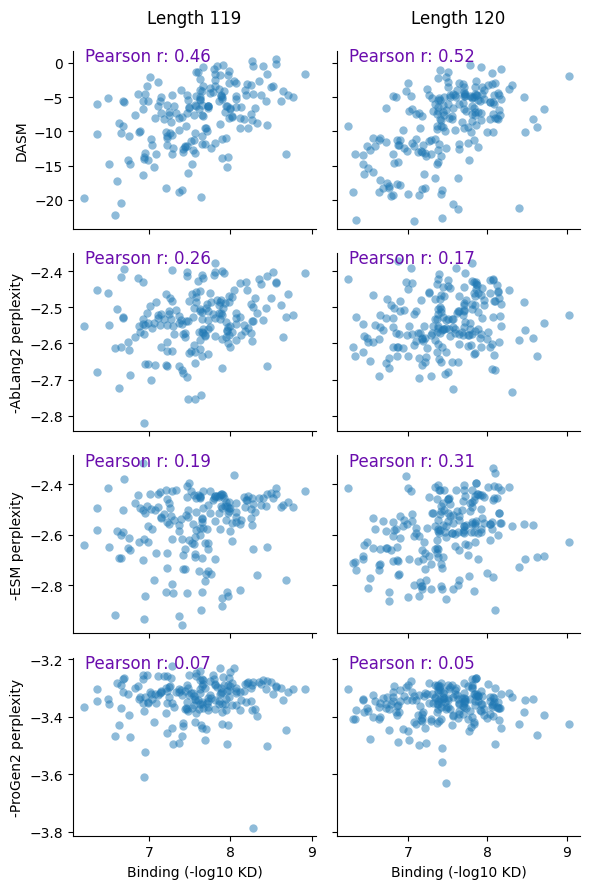

In [9]:
# Plot correlations for both partitions
fig, axs = plt.subplots(4, 2, figsize=(6, 9), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.3)

correlations = []
for j, (length, partition) in enumerate(sorted(partitions.items())):
    corrs = partition.plot_correlations(axs[:, j])
    correlations.extend(corrs)
    axs[0, j].set_title(f'Length {length}', pad=20)
    
# Set x-axis label only for bottom row    
for ax in axs[-1]:
    #ax.set_xlabel('-log10 KD')
    ax.set_xlabel('Binding (-log10 KD)')

plt.tight_layout()
fig.savefig(f"{figures_dir}/shanehsazzadeh.svg")

In [10]:
# make a dataframe of the correlations
correlations_df = pd.DataFrame(correlations, columns=["Dataset", "Model", "Correlation"])
correlations_df["Model"] = correlations_df["Model"].replace({"dasm": "DASM", "neg ablang": "AbLang2", "neg esm": "ESM", "neg progen": "ProGen2"})
correlations_df.to_csv(f"_output/correlations_shane.csv", index=False)
correlations_df

,Dataset,Model,Correlation
0,Shane. Trast. zero 119,DASM,0.458353
1,Shane. Trast. zero 119,AbLang2,0.262539
2,Shane. Trast. zero 119,ESM,0.190971
3,Shane. Trast. zero 119,ProGen2,0.074493
4,Shane. Trast. zero 120,DASM,0.517775
5,Shane. Trast. zero 120,AbLang2,0.166075
6,Shane. Trast. zero 120,ESM,0.307862
7,Shane. Trast. zero 120,ProGen2,0.051981


In [11]:
csv_data = """model,parameters,eval_time_seconds
ProGen2-small,151M,1083.00
DASM,1-4M,2.55
AbLang2,45M,1942.70
ESM,650M-3B,6698.00"""

df = pd.read_csv(io.StringIO(csv_data))
latex_table = df.to_latex(index=False, float_format=lambda x: '%.2f' % x)
print(latex_table)

\begin{tabular}{llr}
\toprule
model & parameters & eval_time_seconds \\
\midrule
ProGen2-small & 151M & 1083.00 \\
DASM & 1-4M & 2.55 \\
AbLang2 & 45M & 1942.70 \\
ESM & 650M-3B & 6698.00 \\
\bottomrule
\end{tabular}

